In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub

# Downloading the latest version
path = kagglehub.dataset_download("threnjen/2019-airline-delays-and-cancellations")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\arin singh mashta\.cache\kagglehub\datasets\threnjen\2019-airline-delays-and-cancellations\versions\9


In [4]:
csv_file = os.path.join(path, "full_data_flightdelay.csv") 

# Loading the dataset into  Pandas DataFrame
data_df = pd.read_csv(csv_file)

# Displaying the first few rows of the dataset
data_df.head()


carrier_delays = {}
for carrier in data_df['CARRIER_NAME'].unique():
    carrier_df = data_df[(data_df['CARRIER_NAME'] == carrier)]
    delay_sum = carrier_df["DEP_DEL15"].sum()
    carrier_delays[carrier] = carrier_delays.get(carrier, 0) + delay_sum
carrier_delays

{'Southwest Airlines Co.': np.int64(271281),
 'Delta Air Lines Inc.': np.int64(137361),
 'Spirit Air Lines': np.int64(35585),
 'Frontier Airlines Inc.': np.int64(31536),
 'Alaska Airlines Inc.': np.int64(39417),
 'Hawaiian Airlines Inc.': np.int64(6521),
 'American Airlines Inc.': np.int64(181350),
 'United Air Lines Inc.': np.int64(117468),
 'JetBlue Airways': np.int64(68480),
 'Allegiant Air': np.int64(8072),
 'SkyWest Airlines Inc.': np.int64(104124),
 'Mesa Airlines Inc.': np.int64(34525),
 'American Eagle Airlines Inc.': np.int64(41153),
 'Midwest Airline, Inc.': np.int64(49163),
 'Comair Inc.': np.int64(42687),
 'Endeavor Air Inc.': np.int64(35641),
 'Atlantic Southeast Airlines': np.int64(23004)}

In [5]:
#data cleaning

# Step 1: Detecting null values and Counting the total number of nulls
null = pd.isnull(data_df)
print(null.head()) 

total_null_value = pd.isnull(data_df).sum().sum()
print(f'Total number of null values: {total_null_value}')

# Step 2: List of missing values representations and Replacing missing values with np.nan directly
missing_vals = ["NA", " ", None, np.nan, "?"]
data_df.replace(missing_vals, np.nan, inplace=True)

# Verifying if the values were replaced
print(data_df.isnull().sum())

# Step 3: Removing unnecessary columns
data_df = data_df.drop(['LATITUDE', 'LONGITUDE', 'SEGMENT_NUMBER', 'PLANE_AGE', 
                         'PREVIOUS_AIRPORT'], axis=1)

# Step 4: Filling categorical columns with mode
for column in data_df.select_dtypes(include=['object']).columns:
    data_df[column] = data_df[column].fillna(data_df[column].mode()[0])

# Step 5: Converting 'date' columns to datetime and applying engineering features
if 'MONTH' in data_df.columns and 'DAY_OF_WEEK' in data_df.columns:
    data_df['DEP_MONTH'] = data_df['MONTH'] 
    data_df['DEP_WEEKDAY'] = data_df['DAY_OF_WEEK'] 

# Step 6: Listing numerical columns to scale them to standarize the data
numerical_columns = ['MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP', 
                     'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 
                     'AIRPORT_FLIGHTS_MONTH', 'TMAX', 'AWND', 
                     'DEP_MONTH', 'DEP_WEEKDAY'] 

# Standardizing the numerical data
scaler = StandardScaler()
scaled_data_set = scaler.fit_transform(data_df[numerical_columns])

# Creating a DataFrame for the scaled data with the same column names
scaled_df = pd.DataFrame(scaled_data_set, columns=numerical_columns)

# Concatenating the scaled columns back to the original DataFrame
data_df = pd.concat([data_df.drop(columns=numerical_columns), scaled_df], axis=1)

# Displaying the first few rows of the new cleaned, formatted, and scaled DataFrame
print(data_df.head())


   MONTH  DAY_OF_WEEK  DEP_DEL15  DEP_TIME_BLK  DISTANCE_GROUP  \
0  False        False      False         False           False   
1  False        False      False         False           False   
2  False        False      False         False           False   
3  False        False      False         False           False   
4  False        False      False         False           False   

   SEGMENT_NUMBER  CONCURRENT_FLIGHTS  NUMBER_OF_SEATS  CARRIER_NAME  \
0           False               False            False         False   
1           False               False            False         False   
2           False               False            False         False   
3           False               False            False         False   
4           False               False            False         False   

   AIRPORT_FLIGHTS_MONTH  ...  PLANE_AGE  DEPARTING_AIRPORT  LATITUDE  \
0                  False  ...      False              False     False   
1                  False

In [6]:
time_blocks_order = [
    'Early Morning & Late Night',  # 0001-0559
    'Morning',                     # 0600-1159
    'Afternoon',                   # 1200-1659
    'Evening',                     # 1700-1959
    'Night'                        # 2000-2359
]

data_df['PART_OF_DAY'] = pd.cut(
    data_df['DEP_TIME_BLK'].map(lambda x: int(x.split('-')[0])),
    bins=[0, 600, 1200, 1700, 2000, 2400],
    labels=time_blocks_order,
    right=False
)

data_df[["DEP_TIME_BLK", "PART_OF_DAY"]].head()

DEP_TIME_BLK                 PART_OF_DAY
0    0800-0859                     Morning
1    0700-0759                     Morning
2    0600-0659                     Morning
3    0600-0659                     Morning
4    0001-0559  Early Morning & Late Night

#Exploratory Data Analysis

In [7]:
data_df.tail() #observing last rows in dataset

DEP_DEL15 DEP_TIME_BLK            CARRIER_NAME  \
6489057          0    2300-2359  Hawaiian Airlines Inc.   
6489058          0    1800-1859  Hawaiian Airlines Inc.   
6489059          0    2000-2059  Hawaiian Airlines Inc.   
6489060          0    2100-2159  Hawaiian Airlines Inc.   
6489061          1    2100-2159  Hawaiian Airlines Inc.   

         AIRLINE_FLIGHTS_MONTH  AIRLINE_AIRPORT_FLIGHTS_MONTH  \
6489057                   7268                            757   
6489058                   7268                            757   
6489059                   7268                            757   
6489060                   7268                            757   
6489061                   7268                            757   

         AVG_MONTHLY_PASS_AIRPORT  AVG_MONTHLY_PASS_AIRLINE  \
6489057                    133573                    905990   
6489058                    133573                    905990   
6489059                    133573                    905990   
6489060                    133573                    905990   
6489061                    133573                    905990   

         FLT_ATTENDANTS_PER_PASS  GROUND_SERV_PER_PASS DEPARTING_AIRPORT  ...  \
6489057                  0.00012              0.000198     Lihue Airport  ...   
6489058                  0.00012              0.000198     Lihue Airport  ...   
6489059                  0.00012              0.000198     Lihue Airport  ...   
6489060                  0.00012              0.000198     Lihue Airport  ...   
6489061                  0.00012              0.000198     Lihue Airport  ...   

         DAY_OF_WEEK  DISTANCE_GROUP  CONCURRENT_FLIGHTS  NUMBER_OF_SEATS  \
6489057     1.535887       -1.184226           -1.154629          -0.2312   
6489058     1.535887       -1.184226           -1.201117          -0.2312   
6489059     1.535887       -1.184226           -1.201117          -0.2312   
6489060     1.535887       -1.184226           -1.154629          -0.2312   
6489061     1.535887       -1.184226           -1.154629          -0.2312   

         AIRPORT_FLIGHTS_MONTH      TMAX      AWND  DEP_MONTH  DEP_WEEKDAY  \
6489057              -1.285842  0.682794  1.903943   1.587628     1.535887   
6489058              -1.285842  0.682794  1.903943   1.587628     1.535887   
6489059              -1.285842  0.682794  1.903943   1.587628     1.535887   
6489060              -1.285842  0.682794  1.903943   1.587628     1.535887   
6489061              -1.285842  0.682794  1.903943   1.587628     1.535887   

         PART_OF_DAY  
6489057        Night  
6489058      Evening  
6489059        Night  
6489060        Night  
6489061        Night  

[5 rows x 24 columns]

In [8]:
data_df.info() #gives basic information of dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 24 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   DEP_DEL15                      int64   
 1   DEP_TIME_BLK                   object  
 2   CARRIER_NAME                   object  
 3   AIRLINE_FLIGHTS_MONTH          int64   
 4   AIRLINE_AIRPORT_FLIGHTS_MONTH  int64   
 5   AVG_MONTHLY_PASS_AIRPORT       int64   
 6   AVG_MONTHLY_PASS_AIRLINE       int64   
 7   FLT_ATTENDANTS_PER_PASS        float64 
 8   GROUND_SERV_PER_PASS           float64 
 9   DEPARTING_AIRPORT              object  
 10  PRCP                           float64 
 11  SNOW                           float64 
 12  SNWD                           float64 
 13  MONTH                          float64 
 14  DAY_OF_WEEK                    float64 
 15  DISTANCE_GROUP                 float64 
 16  CONCURRENT_FLIGHTS             float64 
 17  NUMBER_OF_SEATS            

In [9]:
data_df.describe() #Detailed insight about dataset

DEP_DEL15  AIRLINE_FLIGHTS_MONTH  AIRLINE_AIRPORT_FLIGHTS_MONTH  \
count  6.489062e+06           6.489062e+06                   6.489062e+06   
mean   1.891441e-01           6.296058e+04                   3.459251e+03   
std    3.916231e-01           3.438223e+04                   4.251139e+03   
min    0.000000e+00           5.582000e+03                   1.000000e+00   
25%    0.000000e+00           2.503400e+04                   6.540000e+02   
50%    0.000000e+00           7.087800e+04                   2.251000e+03   
75%    0.000000e+00           8.631200e+04                   4.806000e+03   
max    1.000000e+00           1.177280e+05                   2.183700e+04   

       AVG_MONTHLY_PASS_AIRPORT  AVG_MONTHLY_PASS_AIRLINE  \
count              6.489062e+06              6.489062e+06   
mean               1.588639e+06              7.814970e+06   
std                1.123847e+06              5.046882e+06   
min                7.047600e+04              4.737940e+05   
25%                6.732210e+05              2.688839e+06   
50%                1.486066e+06              8.501631e+06   
75%                2.006675e+06              1.246018e+07   
max                4.365661e+06              1.338300e+07   

       FLT_ATTENDANTS_PER_PASS  GROUND_SERV_PER_PASS          PRCP  \
count             6.489062e+06          6.489062e+06  6.489062e+06   
mean              9.753707e-05          1.355612e-04  1.037063e-01   
std               8.644459e-05          4.649970e-05  3.432134e-01   
min               0.000000e+00          7.134695e-06  0.000000e+00   
25%               3.419267e-05          9.889412e-05  0.000000e+00   
50%               6.178236e-05          1.246511e-04  0.000000e+00   
75%               1.441659e-04          1.772872e-04  2.000000e-02   
max               3.484077e-04          2.289855e-04  1.163000e+01   

               SNOW          SNWD         MONTH   DAY_OF_WEEK  DISTANCE_GROUP  \
count  6.489062e+06  6.489062e+06  6.489062e+06  6.489062e+06    6.489062e+06   
mean   3.159310e-02  9.152397e-02 -5.970035e-16 -8.304368e-17   -9.562287e-17   
std    3.170163e-01  7.281285e-01  1.000000e+00  1.000000e+00    1.000000e+00   
min    0.000000e+00  0.000000e+00 -1.650664e+00 -1.471330e+00   -1.184226e+00   
25%    0.000000e+00  0.000000e+00 -7.674933e-01 -9.701274e-01   -7.644518e-01   
50%    0.000000e+00  0.000000e+00  1.156772e-01  3.227827e-02   -3.446775e-01   
75%    0.000000e+00  0.000000e+00  9.988477e-01  1.034684e+00    4.948711e-01   
max    1.720000e+01  2.520000e+01  1.587628e+00  1.535887e+00    3.013517e+00   

       CONCURRENT_FLIGHTS  NUMBER_OF_SEATS  AIRPORT_FLIGHTS_MONTH  \
count        6.489062e+06     6.489062e+06           6.489062e+06   
mean        -3.819309e-17     1.419451e-16           1.264927e-17   
std          1.000000e+00     1.000000e+00           1.000000e+00   
min         -1.247606e+00    -1.931876e+00          -1.310503e+00   
25%         -7.827190e-01    -9.416091e-01          -8.302885e-01   
50%         -2.248544e-01     1.993507e-01          -1.269917e-01   
75%          5.189650e-01     8.236494e-01           5.577527e-01   
max          3.773175e+00     4.375694e+00           2.553387e+00   

               TMAX          AWND     DEP_MONTH   DEP_WEEKDAY  
count  6.489062e+06  6.489062e+06  6.489062e+06  6.489062e+06  
mean  -5.847046e-16  2.639353e-17 -5.970035e-16 -8.304368e-17  
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
min   -4.438894e+00 -2.312152e+00 -1.650664e+00 -1.471330e+00  
25%   -6.793570e-01 -6.988928e-01 -7.674933e-01 -9.701274e-01  
50%    1.379335e-01 -1.417363e-01  1.156772e-01  3.227827e-02  
75%    7.917659e-01  5.401567e-01  9.988477e-01  1.034684e+00  
max    2.371861e+00  7.051404e+00  1.587628e+00  1.535887e+00

In [10]:
data_df = data_df.sample(n = 5000, random_state = 42).reset_index(drop = True)

<Axes: >

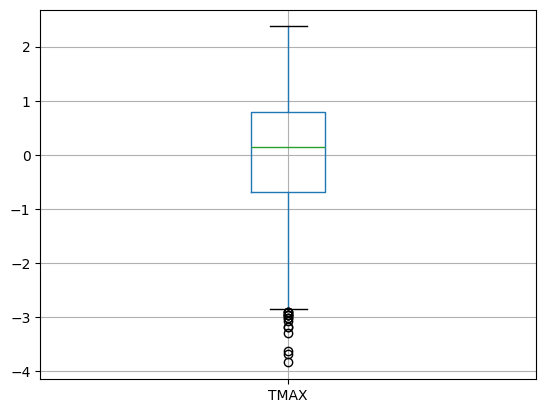

In [11]:
data_df[["TMAX"]].boxplot() #describes impact of temparature on flight operation

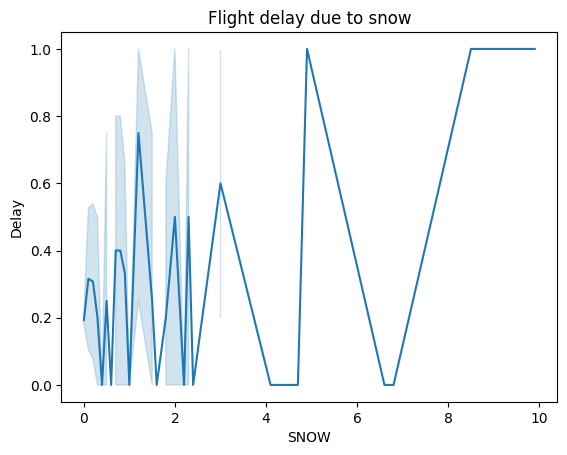

In [12]:
sns.lineplot(data=data_df, x='SNOW', y='DEP_DEL15')
plt.xlabel('SNOW')
plt.ylabel('Delay')
plt.title('Flight delay due to snow')
plt.show()

<Figure size 1000x600 with 0 Axes>

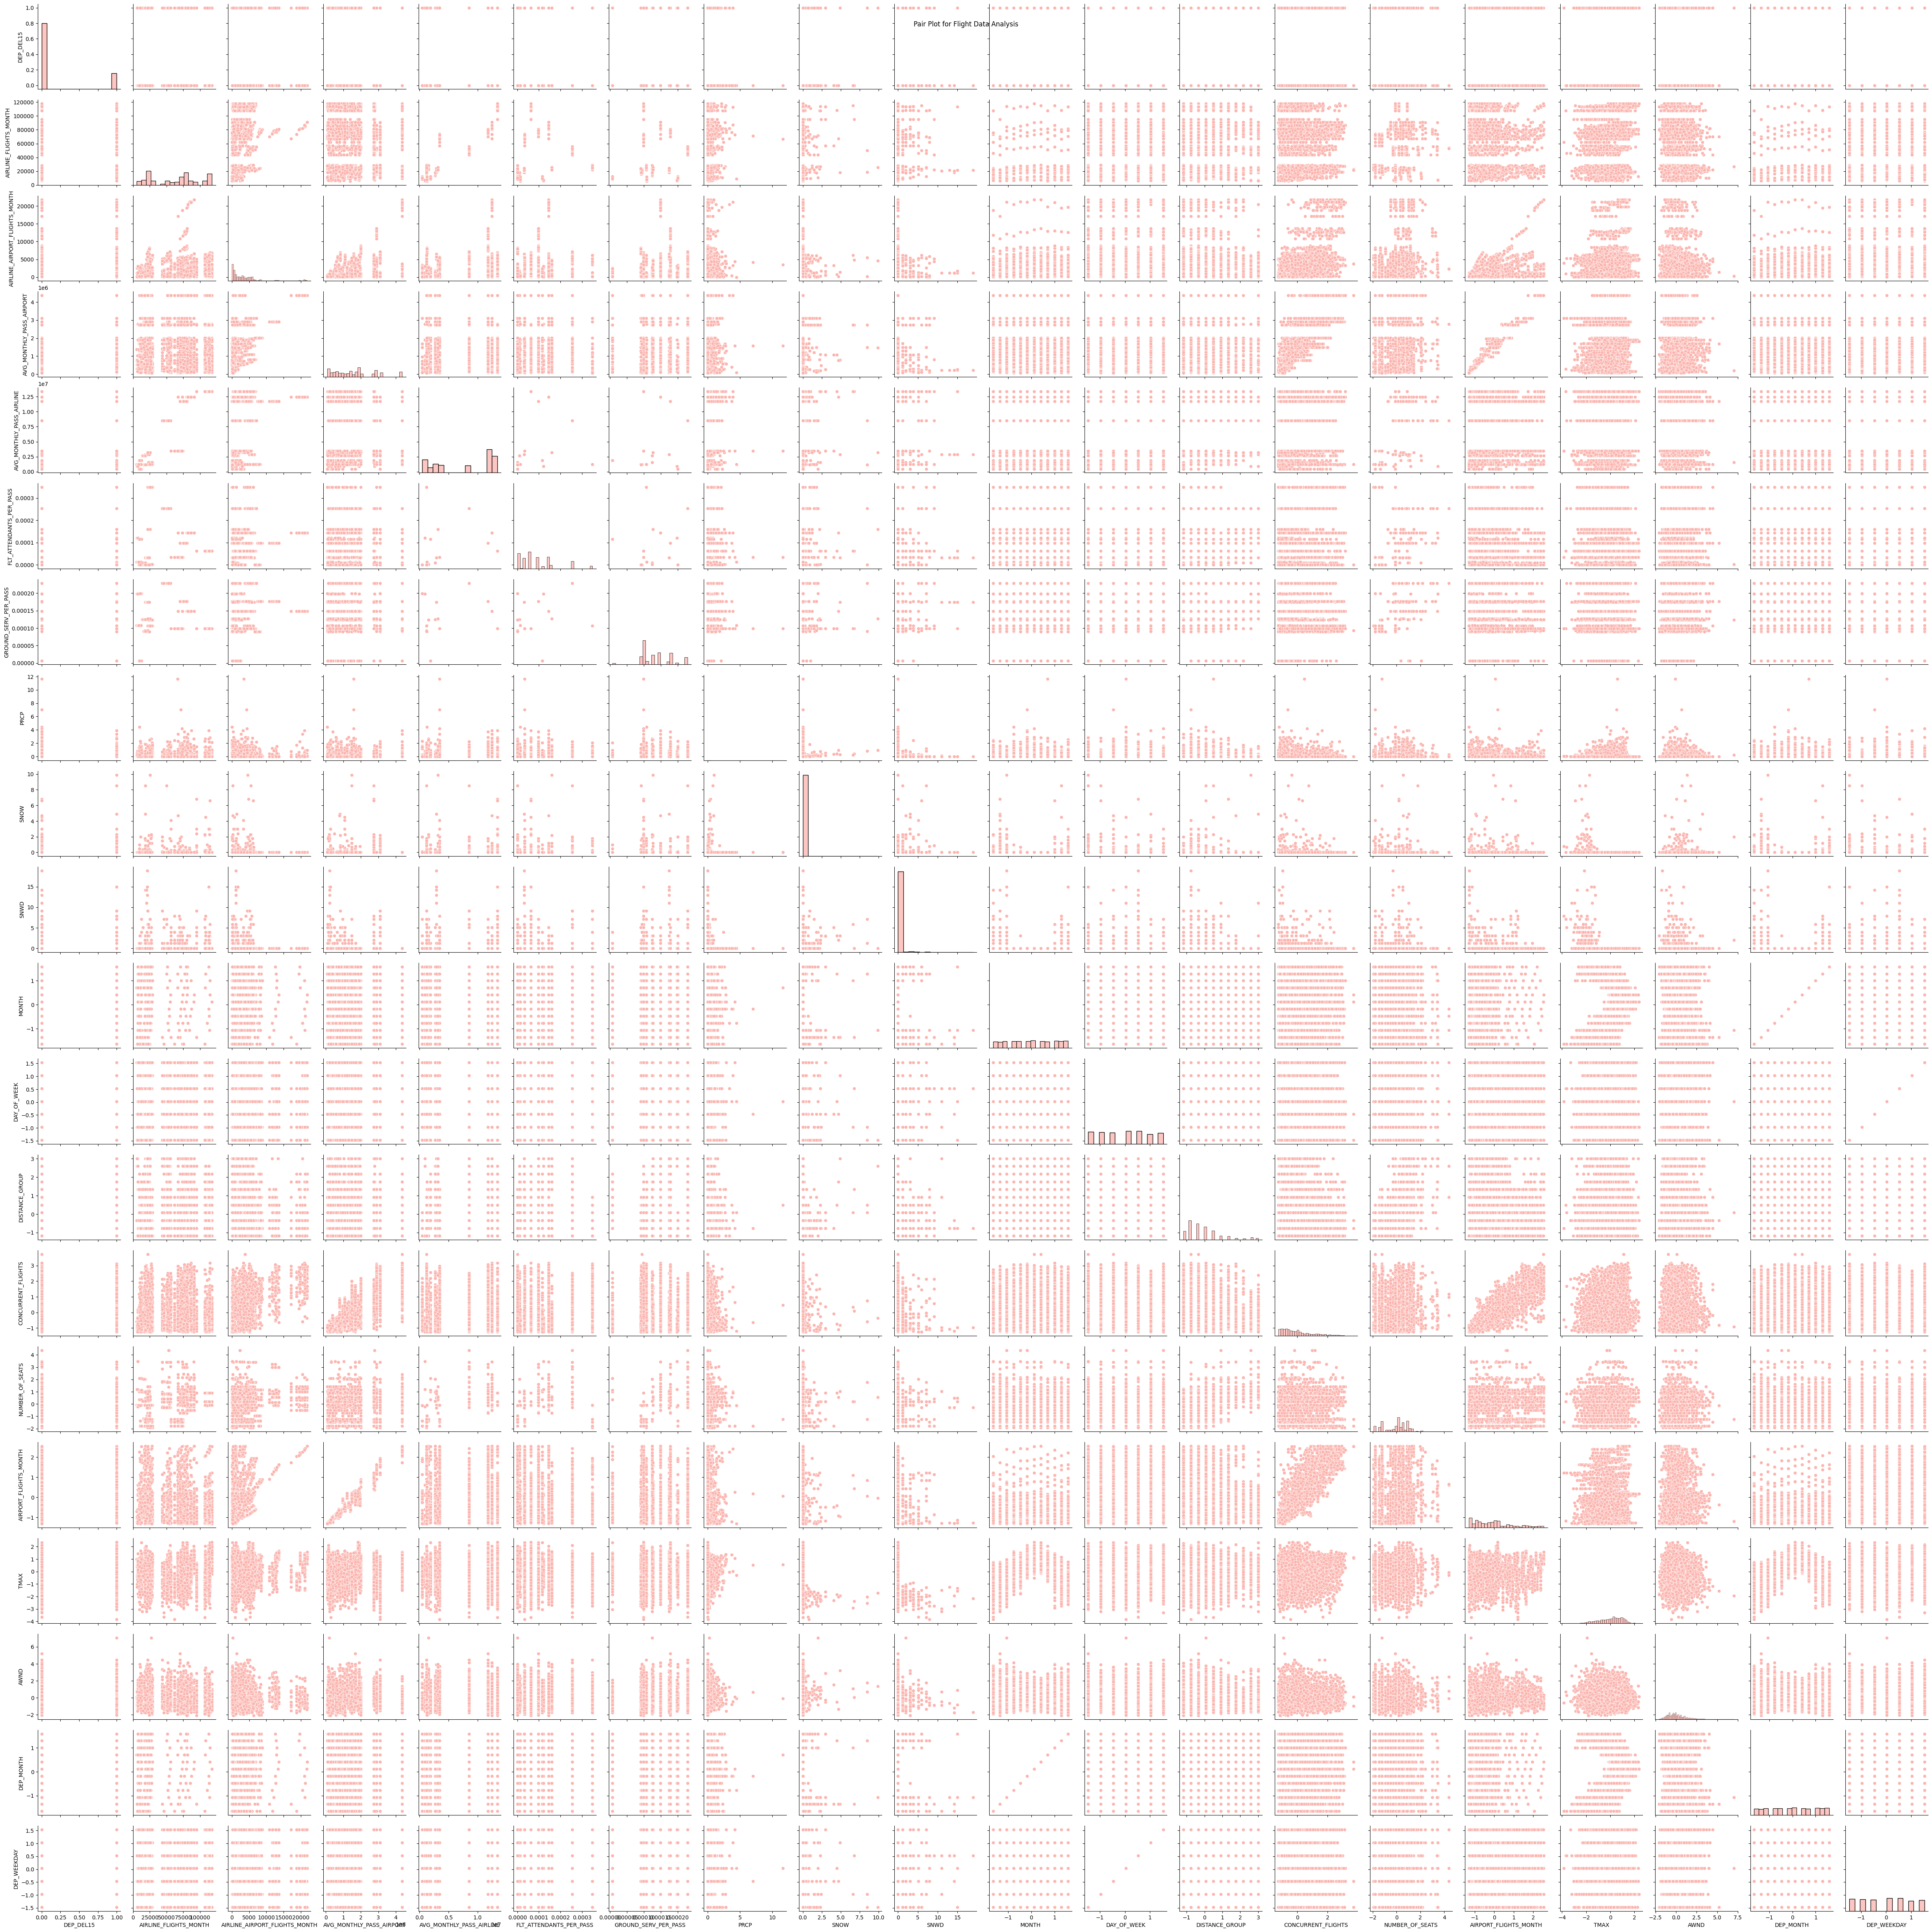

In [13]:
sns.set_palette("Pastel1")
plt.figure(figsize=(10, 6))
sns.pairplot(data_df)
plt.suptitle('Pair Plot for Flight Data Analysis')
plt.show()

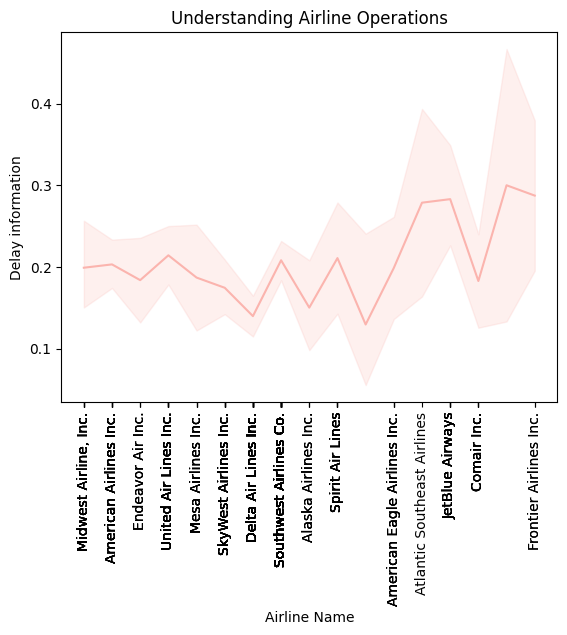

In [14]:
sns.lineplot(data=data_df, x='CARRIER_NAME', y='DEP_DEL15')
plt.xlabel('Airline Name')
plt.ylabel('Delay information')
plt.title('Understanding Airline Operations')

plt.xticks(rotation='vertical')
plt.xticks(data_df['CARRIER_NAME'][::50])
plt.show()

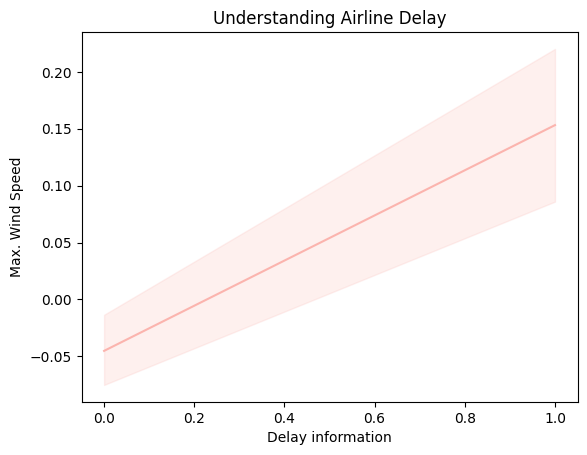

In [15]:
sns.lineplot(data=data_df, x='DEP_DEL15', y='AWND')
plt.xlabel('Delay information')
plt.ylabel('Max. Wind Speed')
plt.title('Understanding Airline Delay')
plt.show()

#PHASE 2 

In [16]:
# Importing necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,precision_score,f1_score,classification_report,ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from collections import OrderedDict
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

Model Evaluation Metrics:
Mean Squared Error (MSE): 0.1610
Mean Absolute Error (MAE): 0.3163
R² Score: 0.0088


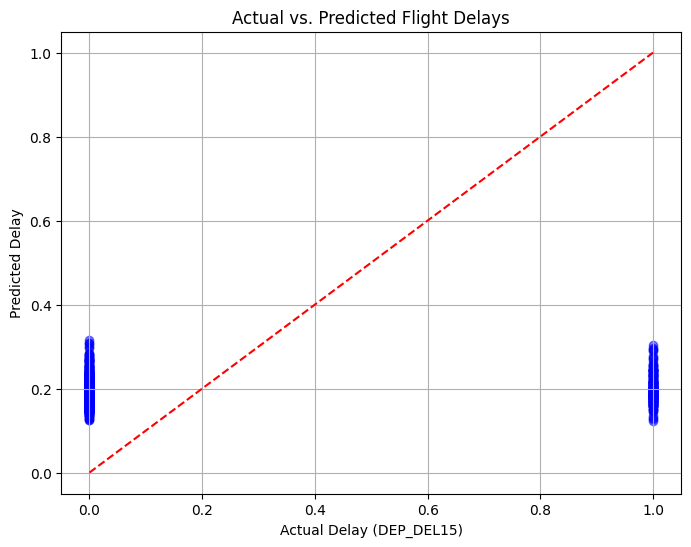

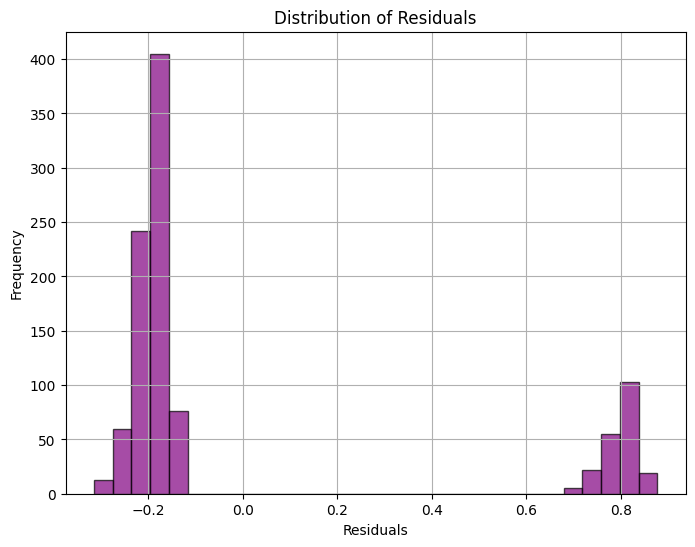

In [17]:
#Linear Regression
X = data_df[['TMAX', 'AWND', 'DISTANCE_GROUP', 'DEP_WEEKDAY', 'DEP_MONTH']]  
y = data_df['DEP_DEL15']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()


lr_model.fit(X_train, y_train)


y_pred = lr_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel("Actual Delay (DEP_DEL15)")
plt.ylabel("Predicted Delay")
plt.title("Actual vs. Predicted Flight Delays")
plt.grid(True)
plt.show()


residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black', color='purple', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.show()

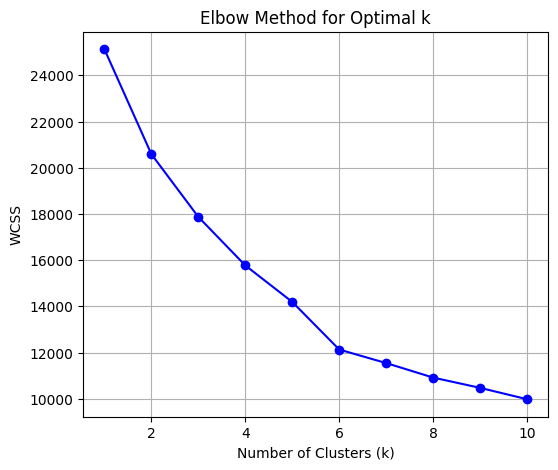

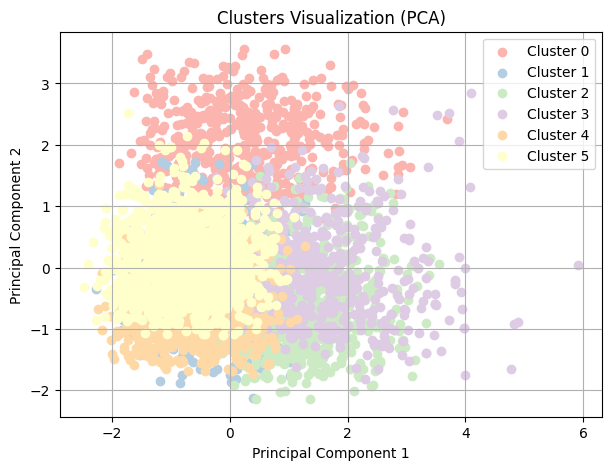

Cluster Centroids:
       TMAX      AWND  DISTANCE_GROUP  DEP_WEEKDAY  DEP_MONTH
0  0.093530 -0.110639        2.142597     0.056357  -0.045137
1 -0.890998 -0.219660       -0.260507     0.123757   1.363997
2 -0.992841 -0.196472       -0.254309    -0.164954  -1.276202
3 -0.280470  1.958802       -0.047860    -0.032242  -0.408843
4  0.737658 -0.331902       -0.285126    -1.042722   0.215560
5  0.729316 -0.275462       -0.322884     0.844531   0.080877
K-Means Clustering Evaluation Metrics:
Silhouette Score: 0.2081
Davies-Bouldin Index: 1.3207


In [18]:
#K-Means Clustering

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score


clustering_features = ['TMAX', 'AWND', 'DISTANCE_GROUP', 'DEP_WEEKDAY', 'DEP_MONTH']
X_clustering = data_df[clustering_features]


wcss = []
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_clustering)
    wcss.append(kmeans.inertia_)  


plt.figure(figsize=(6, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


k = 6  
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_clustering)


data_df['Cluster'] = cluster_labels

cluster_visulaize = PCA(n_components=2)
X_pca = cluster_visulaize.fit_transform(X_clustering)

plt.figure(figsize=(7, 5))
for cluster in range(6):
    plt.scatter(X_pca[cluster_labels == cluster, 0], X_pca[cluster_labels == cluster, 1], label=f'Cluster {cluster}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualization (PCA)')
plt.legend()
plt.grid(True)
plt.show()


centroids = pd.DataFrame(kmeans.cluster_centers_, columns=clustering_features)
print("Cluster Centroids:")
print(centroids)

evaluation_silhouette = silhouette_score(X_clustering, cluster_labels)
evaluation_db_score = davies_bouldin_score(X_clustering, cluster_labels)

print("K-Means Clustering Evaluation Metrics:")
print(f"Silhouette Score: {evaluation_silhouette:.4f}")
print(f"Davies-Bouldin Index: {evaluation_db_score:.4f}")

In [19]:
block_num = {
    'Early Morning & Late Night': 1,
    'Morning' : 2,
    'Afternoon' : 3,
    'Evening' : 4,
    'Night' : 5
}
data_df['PART_OF_DAY'] = data_df['PART_OF_DAY'].map(block_num)
data_df[['DEP_TIME_BLK' ,'PART_OF_DAY']].head()

DEP_TIME_BLK PART_OF_DAY
0    1500-1559           3
1    2200-2259           5
2    1900-1959           4
3    1700-1759           4
4    0800-0859           2

In [20]:
X = data_df[["PRCP", "AWND", "SNOW", "SNWD", "PART_OF_DAY"]].to_numpy()
y = data_df["DEP_DEL15"].to_numpy()

X_Train, X_Test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Initialize DataFrames to store accuracy and F1 scores
columns = ['k', 'No Scaler', 'MinMaxScaler', 'StandardScaler', 'RobustScaler']
AccurDf = pd.DataFrame(np.nan, index=range(12), columns=columns)
F1ScoreDf = pd.DataFrame(np.nan, index=range(12), columns=columns)

# Set the k values
AccurDf['k'] = F1ScoreDf['k'] = list(range(3, 26, 2))

# Define scalers
scalers = {'No Scaler': None, 'MinMaxScaler': MinMaxScaler(), 'StandardScaler': StandardScaler(), 'RobustScaler': RobustScaler()}

# Loop through k values and scalers
for i, k in enumerate(range(3, 26, 2)):
    for scaler_name, scaler in scalers.items():
        # Scale data if scaler is not None
        if scaler:
            X_Train_scaled = scaler.fit_transform(X_Train)
            X_Test_scaled = scaler.transform(X_Test)
        else:
            X_Train_scaled, X_Test_scaled = X_Train, X_Test

        # Train the KNN classifier and make predictions
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_Train_scaled, y_train)
        y_pred = knn.predict(X_Test_scaled)

        # Calculate accuracy
        accuracy = knn.score(X_Test_scaled, y_test)
        AccurDf.loc[i, scaler_name] = accuracy

        # Calculate average weighted F1 score
        f1 = f1_score(y_test, y_pred, average='weighted')
        F1ScoreDf.loc[i, scaler_name] = f1

# Find the best scaler and k for accuracy
best_acc_index = AccurDf.drop(columns=['k']).values.argmax()
best_acc_k = AccurDf['k'][best_acc_index // 4]
best_acc_scaler = columns[1:][best_acc_index % 4]

# Find the best scaler and k for average weighted F1 score
best_f1_index = F1ScoreDf.drop(columns=['k']).values.argmax()
best_f1_k = F1ScoreDf['k'][best_f1_index // 4]
best_f1_scaler = columns[1:][best_f1_index % 4]

print("Accuracy Table")
print("Best accuracy: Scaler = {}, k = {}".format(best_acc_scaler, best_acc_k))
print("Best average weighted F1 score: Scaler = {}, k = {}".format(best_f1_scaler, best_f1_k))

# Display the DataFrames
AccurDf

Accuracy Table
Best accuracy: Scaler = RobustScaler, k = 23
Best average weighted F1 score: Scaler = StandardScaler, k = 7


k  No Scaler  MinMaxScaler  StandardScaler  RobustScaler
0    3      0.737         0.739           0.748         0.747
1    5      0.770         0.761           0.776         0.766
2    7      0.786         0.783           0.789         0.774
3    9      0.786         0.785           0.789         0.791
4   11      0.786         0.784           0.787         0.794
5   13      0.786         0.790           0.789         0.789
6   15      0.791         0.796           0.793         0.794
7   17      0.793         0.795           0.794         0.795
8   19      0.794         0.795           0.792         0.796
9   21      0.795         0.794           0.793         0.795
10  23      0.794         0.793           0.793         0.798
11  25      0.795         0.794           0.795         0.797

In [22]:
print('F-1 Score Table')
F1ScoreDf

F-1 Score Table


k  No Scaler  MinMaxScaler  StandardScaler  RobustScaler
0    3   0.714910      0.712139        0.724898      0.724200
1    5   0.720396      0.716917        0.734172      0.721221
2    7   0.728037      0.716691        0.736153      0.715455
3    9   0.710809      0.710258        0.721675      0.722862
4   11   0.710809      0.708107        0.711360      0.724645
5   13   0.702405      0.707967        0.710820      0.707442
6   15   0.703111      0.711111        0.712988      0.713530
7   17   0.704103      0.708793        0.711814      0.712347
8   19   0.704598      0.708793        0.707250      0.709307
9   21   0.705092      0.706457        0.707764      0.706962
10  23   0.704598      0.704103        0.707764      0.710334
11  25   0.705092      0.704598        0.708793      0.707969

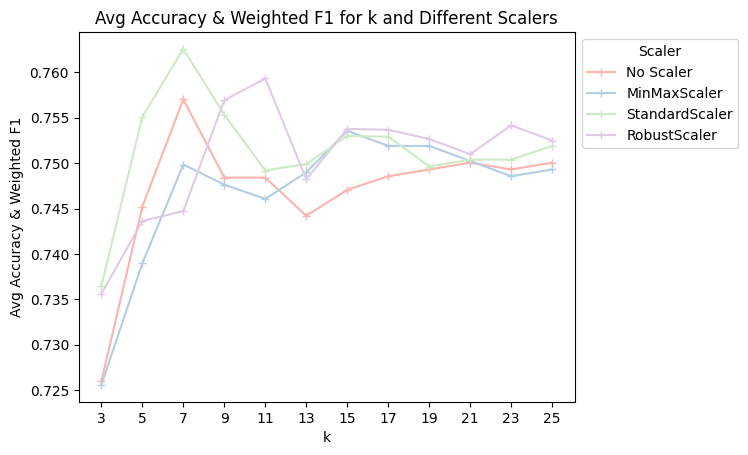

In [23]:
AverageDf = AccurDf.copy()
for scaler_name in columns[1:]:
    AverageDf[scaler_name] = (AccurDf[scaler_name] + F1ScoreDf[scaler_name]) / 2
AverageDf.set_index('k').plot(marker='+')
plt.xlabel('k')
plt.ylabel('Avg Accuracy & Weighted F1')
plt.title('Avg Accuracy & Weighted F1 for k and Different Scalers')
plt.legend(title='Scaler', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(range(3, 26, 2))
plt.show()

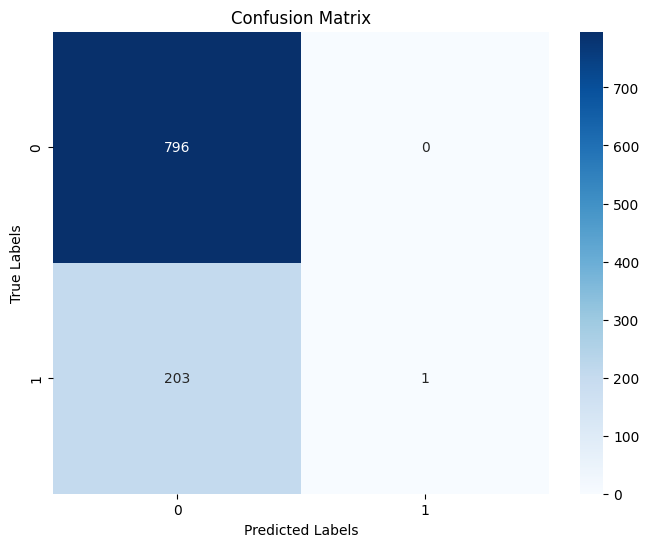

              precision    recall  f1-score   support

           0     0.7968    1.0000    0.8869       796
           1     1.0000    0.0049    0.0098       204

    accuracy                         0.7970      1000
   macro avg     0.8984    0.5025    0.4483      1000
weighted avg     0.8383    0.7970    0.7080      1000



In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = knn.predict(X_Test_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred, digits=4))

#ML model SVM

In [25]:
df_svm = data_df.sample(n = 5000, random_state = 42).reset_index(drop = True)
df_svm.value_counts("DEP_DEL15", normalize=True) * 100

DEP_DEL15
0    80.48
1    19.52
Name: proportion, dtype: float64

In [26]:
X = df_svm[["PRCP", "AWND", "SNOW", "SNWD", "PART_OF_DAY"]].to_numpy()
y = df_svm["DEP_DEL15"].to_numpy()

X_Train, X_Test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
X_Train = scaler.fit_transform(X_Train)
X_Test = scaler.transform(X_Test)

In [27]:
kernels = {'Sigmoid': 'sigmoid'}
results = []

# Iterate over the range of C values and kernel types
for C in range(10, 91, 10):
    for kernel_name, kernel_type in kernels.items():
        svm = SVC(C=C, kernel=kernel_type)
        svm.fit(X_Train, y_train)
        y_pred = svm.predict(X_Test)
        accuracy = svm.score(X_Test, y_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results.append({'C': C, 'Accuracy': accuracy, 'F1_Score': f1})
        print(f"Accuracy for C={C}, kernel={kernel_name}: {accuracy}, F1_Score: {f1}")

results_sigmoid = pd.DataFrame(results)

Accuracy for C=10, kernel=Sigmoid: 0.807, F1_Score: 0.7521261937333074
Accuracy for C=20, kernel=Sigmoid: 0.807, F1_Score: 0.7521261937333074
Accuracy for C=30, kernel=Sigmoid: 0.807, F1_Score: 0.7521261937333074
Accuracy for C=40, kernel=Sigmoid: 0.808, F1_Score: 0.7527214576508879
Accuracy for C=50, kernel=Sigmoid: 0.808, F1_Score: 0.7527214576508879
Accuracy for C=60, kernel=Sigmoid: 0.808, F1_Score: 0.7527214576508879
Accuracy for C=70, kernel=Sigmoid: 0.808, F1_Score: 0.7527214576508879
Accuracy for C=80, kernel=Sigmoid: 0.808, F1_Score: 0.7527214576508879
Accuracy for C=90, kernel=Sigmoid: 0.808, F1_Score: 0.7527214576508879


In [28]:
kernels = {'RBF': 'rbf'}
results = []

for C in range(10, 91, 10):
    for kernel_name, kernel_type in kernels.items():
        svm = SVC(C=C, kernel=kernel_type)
        svm.fit(X_Train, y_train)
        y_pred = svm.predict(X_Test)
        accuracy = svm.score(X_Test, y_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results.append({'C': C, 'Kernel': kernel_name, 'Accuracy': accuracy, 'F1_Score': f1})
        print(f"Accuracy for C={C}, kernel={kernel_name}: {accuracy}, F1_Score: {f1}")
        
results_rbf = pd.DataFrame(results)

Accuracy for C=10, kernel=RBF: 0.822, F1_Score: 0.7425971459934139
Accuracy for C=20, kernel=RBF: 0.822, F1_Score: 0.7425971459934139
Accuracy for C=30, kernel=RBF: 0.822, F1_Score: 0.7425971459934139
Accuracy for C=40, kernel=RBF: 0.821, F1_Score: 0.7421010433827567
Accuracy for C=50, kernel=RBF: 0.821, F1_Score: 0.7421010433827567
Accuracy for C=60, kernel=RBF: 0.821, F1_Score: 0.7421010433827567
Accuracy for C=70, kernel=RBF: 0.821, F1_Score: 0.7421010433827567
Accuracy for C=80, kernel=RBF: 0.821, F1_Score: 0.7421010433827567
Accuracy for C=90, kernel=RBF: 0.821, F1_Score: 0.7421010433827567


In [29]:
# Calculating the average between Accuracy and F1_Score
results_rbf['Average_RBF'] = (results_rbf['Accuracy'] + results_rbf['F1_Score']) / 2
# Selecting only the required columns and renaming them
results_rbf = results_rbf[['C', 'Average_RBF']]

In [30]:
# Calculating the average between Accuracy and F1_Score
results_sigmoid['Average_Sigmoid'] = (results_sigmoid['Accuracy'] + results_sigmoid['F1_Score']) / 2

# Selecting only the required columns
results_sigmoid = results_sigmoid[['C', 'Average_Sigmoid']]

In [31]:
merged_df = pd.merge(results_rbf, results_sigmoid, on='C')
merged_df

C  Average_RBF  Average_Sigmoid
0  10     0.782299         0.779563
1  20     0.782299         0.779563
2  30     0.782299         0.779563
3  40     0.781551         0.780361
4  50     0.781551         0.780361
5  60     0.781551         0.780361
6  70     0.781551         0.780361
7  80     0.781551         0.780361
8  90     0.781551         0.780361

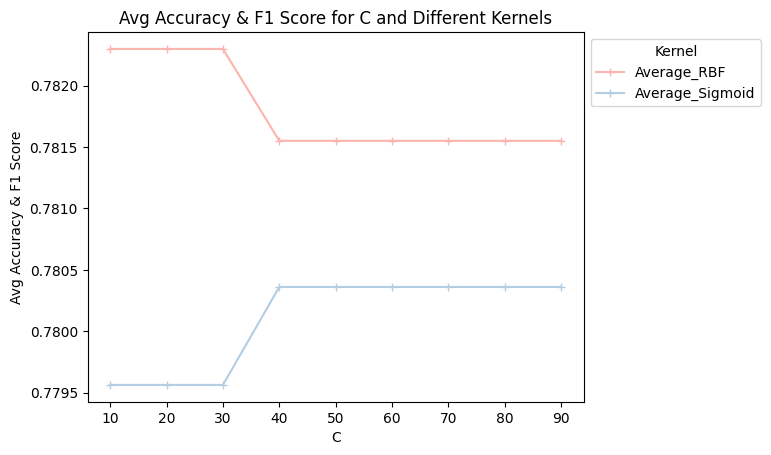

In [32]:
merged_df.set_index('C').plot(marker='+')
plt.xlabel('C')
plt.ylabel('Avg Accuracy & F1 Score')
plt.title('Avg Accuracy & F1 Score for C and Different Kernels')
plt.legend(title='Kernel', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(range(10, 91, 10))
plt.show()

Best average weighted F1 score and Accuracy Kernel: Average_RBF
Accuracy for the best C - 10 is 0.822
Cross Validation value is 0.822



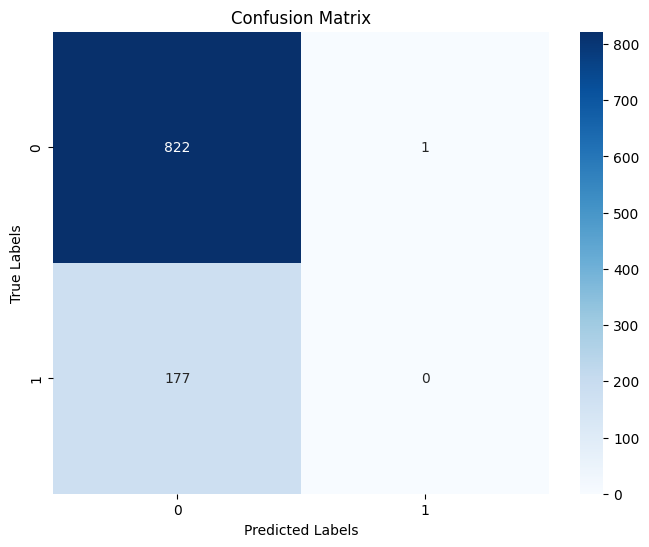

              precision    recall  f1-score   support

           0     0.8228    0.9988    0.9023       823
           1     0.0000    0.0000    0.0000       177

    accuracy                         0.8220      1000
   macro avg     0.4114    0.4994    0.4512      1000
weighted avg     0.6772    0.8220    0.7426      1000



In [33]:
# Step 1: Find the best average weighted F1 score and Accuracy Kernel
best_avg_index = merged_df.drop(columns=['C']).values.argmax()
best_avg_C = merged_df['C'][best_avg_index // 2]
best_avg_kernel = ['Average_RBF', 'Average_Sigmoid'][best_avg_index % 2]
print("Best average weighted F1 score and Accuracy Kernel:", best_avg_kernel)

# Step 2: Train the SVM with the best parameters
kernel_map = {'Average_RBF': 'rbf', 'Average_Sigmoid': 'sigmoid'}
svm = SVC(C=best_avg_C, kernel=kernel_map[best_avg_kernel])
svm.fit(X_Train, y_train)

# Step 3: Calculate and display accuracy
print("Accuracy for the best C -", best_avg_C, "is", svm.score(X_Test, y_test))

# Step 4: Perform cross-validation
print("Cross Validation value is", np.mean(cross_val_score(svm, X_Test, y_test, cv=4)))
print()

# Step 5: Plot confusion matrix manually using seaborn
y_pred = svm.predict(X_Test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
# Show the plot
plt.show()
# Step 6: Display classification report
print(classification_report(y_test, y_pred, digits=4))

#DecisionTree Classifier

Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'criterion': 'entropy'}


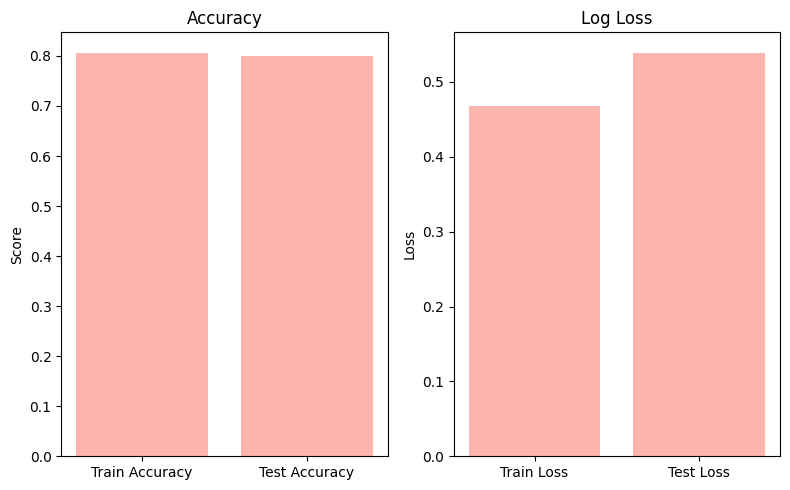

Train Accuracy: 0.8069
Train Loss: 0.4680
Test Accuracy: 0.8000
Test Loss: 0.5393
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support
target_column = 'DEP_DEL15'
X=data_df.drop(columns=[target_column])
y=data_df[target_column]
X=pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
param_distributions={
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
random_search=RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=50, 
    scoring='accuracy',
    cv=5,       # 5-fold cross-validation
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

best_params=random_search.best_params_
print("Best parameters:", best_params)

dec_model=DecisionTreeClassifier(**best_params, random_state=42)
dec_model.fit(X_train, y_train)
y_train_pred=dec_model.predict(X_train)
y_test_pred=dec_model.predict(X_test)
dt_train_acc=accuracy_score(y_train, y_train_pred)
dt_test_acc=accuracy_score(y_test, y_test_pred)
dt_train_loss=log_loss(y_train, dec_model.predict_proba(X_train))
dt_test_loss=log_loss(y_test, dec_model.predict_proba(X_test))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.bar(['Train Accuracy', 'Test Accuracy'], [dt_train_acc, dt_test_acc])
plt.title('Accuracy')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.bar(['Train Loss', 'Test Loss'], [dt_train_loss, dt_test_loss])
plt.title('Log Loss')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

print(f"Train Accuracy: {dt_train_acc:.4f}")
print(f"Train Loss: {dt_train_loss:.4f}")
print(f"Test Accuracy: {dt_test_acc:.4f}")
print(f"Test Loss: {dt_test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

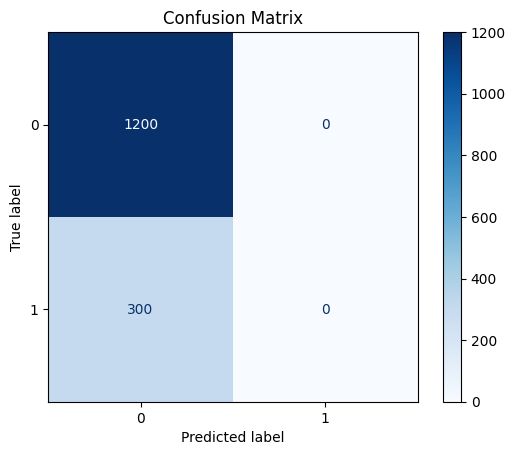

In [35]:
# Decision Tree Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
cmt=confusion_matrix(y_test, y_test_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cmt, display_labels=dec_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

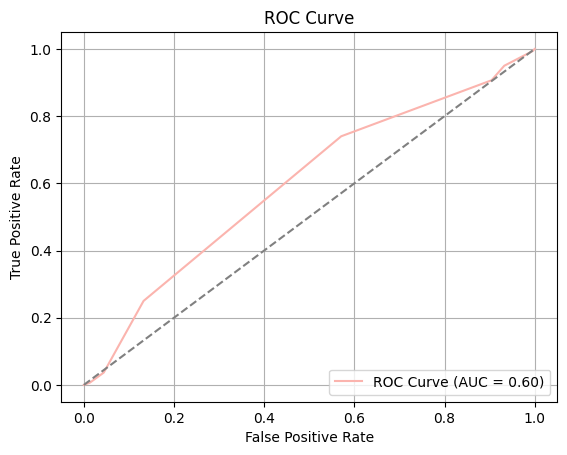

In [36]:
# Decision Tree ROC Curve
y_test_pro=dec_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds=roc_curve(y_test, y_test_pro)
roc_auc=auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

#Logistic Regression

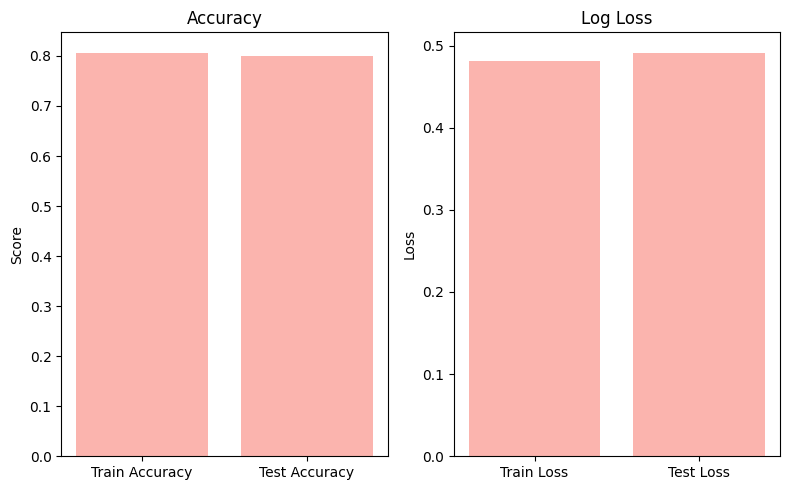

Train Accuracy: 0.8069
Train Loss: 0.4810
Test Accuracy: 0.8000
Test Loss: 0.4915
Precision: 0.5000
Recall: 0.0033
F1 Score: 0.0066


In [37]:
from sklearn.linear_model import LogisticRegression
target_column = 'DEP_DEL15'
X=data_df.drop(columns=[target_column])
y=data_df[target_column]
X=pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
log_model=LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
y_train_pred=log_model.predict(X_train)
y_test_pred=log_model.predict(X_test)
log_train_acc=accuracy_score(y_train, y_train_pred)
log_test_acc=accuracy_score(y_test, y_test_pred)
log_train_loss=log_loss(y_train, log_model.predict_proba(X_train))
log_test_loss=log_loss(y_test, log_model.predict_proba(X_test))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.bar(['Train Accuracy', 'Test Accuracy'], [log_train_acc, log_test_acc])
plt.title('Accuracy')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.bar(['Train Loss', 'Test Loss'], [log_train_loss, log_test_loss])
plt.title('Log Loss')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

print(f"Train Accuracy: {log_train_acc:.4f}")
print(f"Train Loss: {log_train_loss:.4f}")
print(f"Test Accuracy: {log_test_acc:.4f}")
print(f"Test Loss: {log_test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

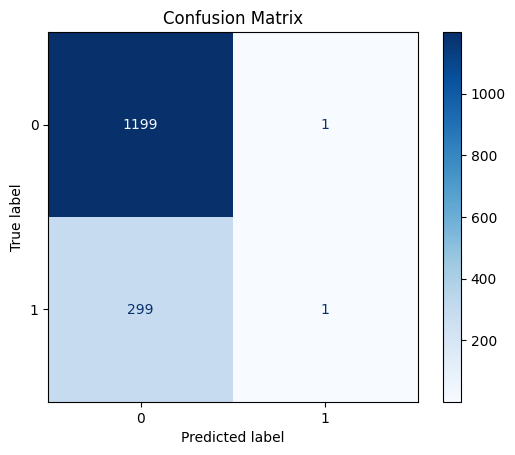

In [38]:
# Logistic Regression Confusion Matrix
cmt=confusion_matrix(y_test, y_test_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cmt, display_labels=log_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

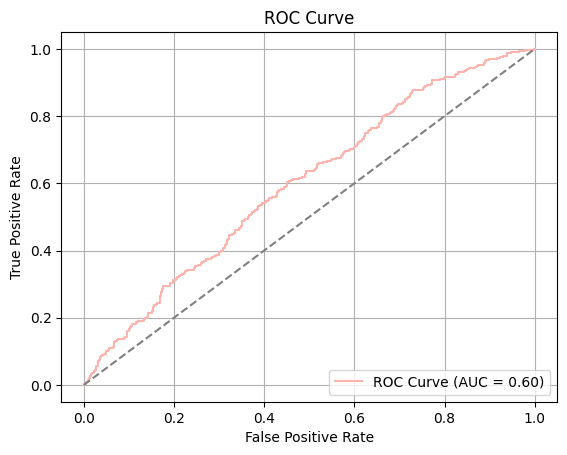

In [39]:
# Logistic Regression ROC Curve
y_test_pro=log_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds=roc_curve(y_test, y_test_pro)
roc_auc=auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()